In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Hyperparameters
batch_size = 64
z_dim = 10        # Latent vector size (small for speed)
lr = 0.0002
epochs = 5        # Few epochs for fast run

# Device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset (MNIST)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_data = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

# Generator - very small network
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.net(z).view(-1, 1, 28, 28)

# Discriminator - very small network
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

# Initialize models
G = Generator().to(device)
D = Discriminator().to(device)

# Optimizers
optim_G = optim.Adam(G.parameters(), lr=lr)
optim_D = optim.Adam(D.parameters(), lr=lr)

# Loss function
criterion = nn.BCELoss()

# Training loop
for epoch in range(epochs):
    for real_imgs, _ in dataloader:
        real_imgs = real_imgs.to(device)
        batch_size = real_imgs.size(0)

        # Labels
        real_labels = torch.ones(batch_size, 1, device=device)
        fake_labels = torch.zeros(batch_size, 1, device=device)

        # Train Discriminator
        optim_D.zero_grad()
        outputs_real = D(real_imgs)
        loss_real = criterion(outputs_real, real_labels)

        noise = torch.randn(batch_size, z_dim, device=device)
        fake_imgs = G(noise)
        outputs_fake = D(fake_imgs.detach())
        loss_fake = criterion(outputs_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optim_D.step()

        # Train Generator
        optim_G.zero_grad()
        outputs = D(fake_imgs)
        loss_G = criterion(outputs, real_labels)  # We want generator to fool D
        loss_G.backward()
        optim_G.step()

    print(f"Epoch [{epoch+1}/{epochs}]  Loss D: {loss_D.item():.4f}, loss G: {loss_G.item():.4f}")

print("Training complete.")


100%|██████████| 9.91M/9.91M [00:01<00:00, 6.07MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 159kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.30MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.03MB/s]


Epoch [1/5]  Loss D: 0.5906, loss G: 1.3306
Epoch [2/5]  Loss D: 0.8521, loss G: 1.1411
Epoch [3/5]  Loss D: 1.1521, loss G: 0.9096
Epoch [4/5]  Loss D: 0.9194, loss G: 1.1312
Epoch [5/5]  Loss D: 1.1254, loss G: 0.9331
Training complete.


Epoch 1, Generator Loss: 6.867493629455566, Discriminator Loss: 0.0019694461952894926


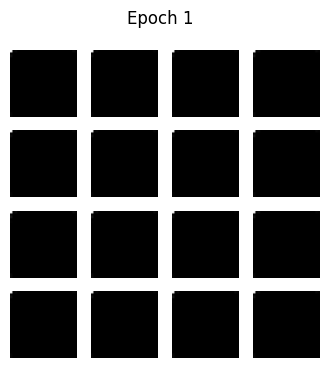